# Analysing PV Cells Using Various Pre-Processing Techniques and a Random Forest Classifier

## 1. Load the Data

The data is loaded and then displayed to identify any potential errors.

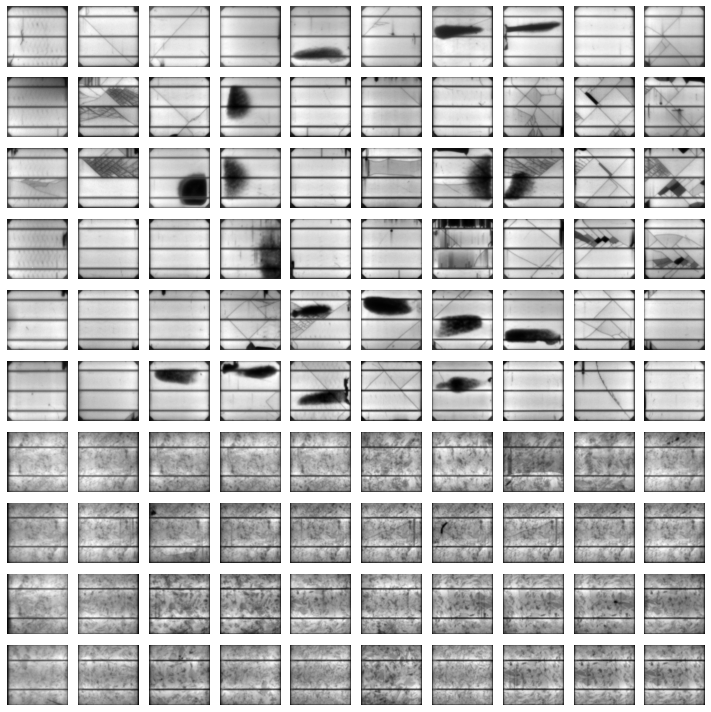

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from elpv_dataset.utils.elpv_reader import load_dataset

images, proba, types = load_dataset()

# Display a 10x10 square of some of the images
num_rows = 10
num_cols = 10

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < len(images):
            # Needs to be colour mapped to grayscale for it to work properly
            axes[i, j].imshow(images[index], cmap='gray')
            axes[i, j].axis('off')

# Adjust spacing and display the subplots
plt.tight_layout()
plt.show()


## 2. Split the Data into a Testing Set and Training Set

A 75:25 training:testing split is used here. The probability values are also mapped so that they are not continuous and can be represented as a class name.

In [39]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

def map_prob_to_class(probability):
    if probability == 0:
        return "Fully functional"
    elif probability > 0 and probability < 0.34:
        return "Possibly defective" 
    elif probability > 0.64 and probability < 0.68 :
        return "Likely defective"
    else:
        return "Certainly defective"
    
types_mapped = np.array([map_prob_to_class(float(probability)) for probability in proba])


training_imgs, testing_imgs, training_labels, testing_labels = train_test_split(images, types_mapped, test_size=0.25, random_state=42)



## 3. Apply Grey Level Normalisation to the Images

This method ensures the consistency in pixel values across diverse images. It adjusts the intensity values of pixels to a standardised range, in this case between -1 and 1.

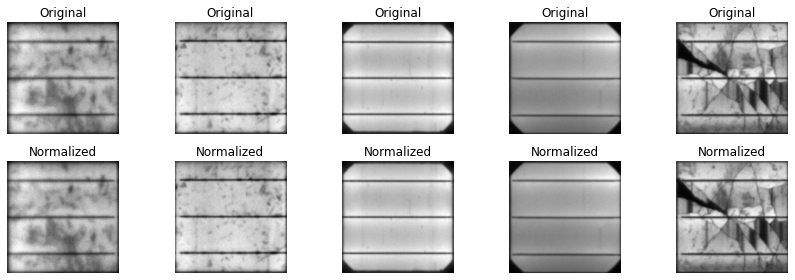

In [40]:
def normalizeImages(images):
    normalized_images = []
    for image in images:
        mean = np.mean(image)
        std = np.std(image)
        normalized_image = (image - mean) / std
        normalized_image = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image))
        normalized_image = normalized_image * 2 - 1  # Rescale to [-1, 1]
        normalized_images.append(normalized_image)
    return normalized_images

training_imgs_normalised = normalizeImages(training_imgs)


# Display a few images before and after normalization
num_images_to_display = 5

fig, axes = plt.subplots(2, num_images_to_display, figsize=(12, 4))

for i in range(num_images_to_display):
    # Display the original image
    axes[0, i].imshow(training_imgs[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Display the normalized image
    axes[1, i].imshow(training_imgs_normalised[i], cmap='gray')
    axes[1, i].set_title("Normalized")
    axes[1, i].axis('off')

# Adjust spacing and display 
plt.tight_layout()
plt.show()


## 4. Apply Anisotropic (Bilateral) Diffusion to the Images

Anisotropic (bilateral) filtering is applied concurrently to the set of images to further refine the data, reducing noise and enhancing the defects.

c:\Users\Cengiz Cimen\AppData\Local\Programs\Python\Python310\lib\concurrent\futures\thread.py:58: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  result = self.fn(*self.args, **self.kwargs)


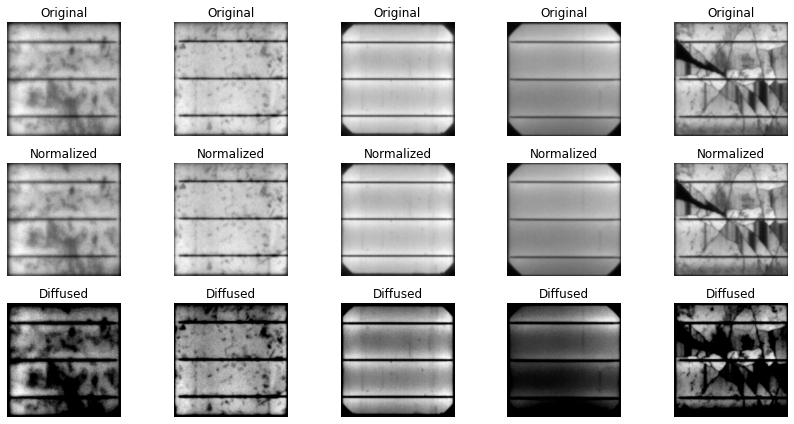

In [41]:
from skimage.filters import rank
from skimage.morphology import disk
import concurrent.futures

def applyAnisotropicDiffusion(images):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        filtered_images = list(executor.map(lambda img: rank.mean_bilateral(img, disk(20), s0=10, s1=10), images))
    return filtered_images

training_imgs_diffused = applyAnisotropicDiffusion(training_imgs_normalised)




num_images_to_display = 5

fig, axes = plt.subplots(3, num_images_to_display, figsize=(12, 6))

for i in range(num_images_to_display):
    # Display the original image
    axes[0, i].imshow(training_imgs[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Display the normalized image
    axes[1, i].imshow(training_imgs_normalised[i], cmap='gray')
    axes[1, i].set_title("Normalized")
    axes[1, i].axis('off')

    # Display the diffused image
    axes[2, i].imshow(training_imgs_diffused[i], cmap='gray')
    axes[2, i].set_title("Diffused")
    axes[2, i].axis('off')

# Adjust spacing and display
plt.tight_layout()
plt.show()


## 5. Threshold the Images Using The Triangle Algorithm

This step is instrumental in that it visually isolates the damage done to the solar modules, greatly enhancing the clarity and robustness of the dataset. 

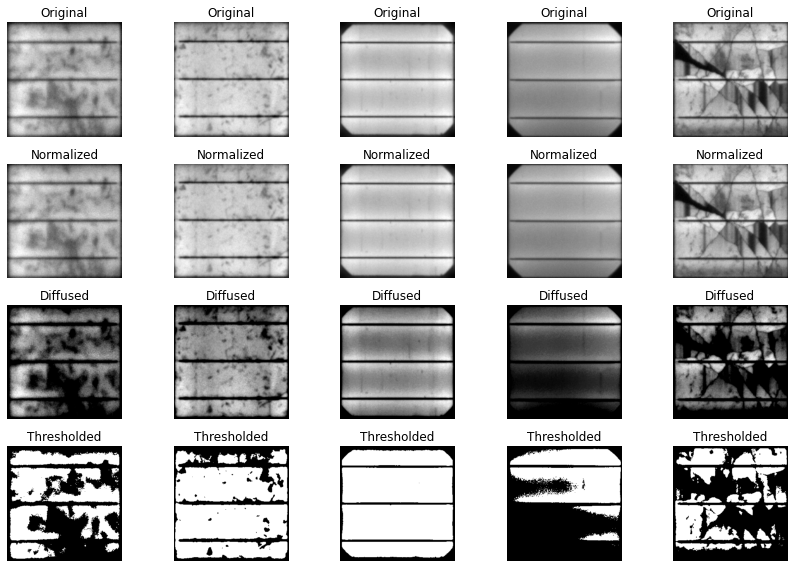

In [42]:
from skimage import measure, filters


def applyThresholding(images):
    binary_images = []
    for image in images:
        image_thresh = filters.threshold_otsu(image)
        binary_image = image > image_thresh
        binary_images.append(binary_image)
    return binary_images


training_imgs_thresholded = applyThresholding(training_imgs_diffused)


# Display a few sets of images: original, normalized, and diffused
num_images_to_display = 5

fig, axes = plt.subplots(4, num_images_to_display, figsize=(12, 8))

for i in range(num_images_to_display):
    # Display the original image
    axes[0, i].imshow(training_imgs[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Display the normalized image
    axes[1, i].imshow(training_imgs_normalised[i], cmap='gray')
    axes[1, i].set_title("Normalized")
    axes[1, i].axis('off')

    # Display the diffused image
    axes[2, i].imshow(training_imgs_diffused[i], cmap='gray')
    axes[2, i].set_title("Diffused")
    axes[2, i].axis('off')

    # Display the thresholded image
    axes[3, i].imshow(training_imgs_thresholded[i], cmap='gray')
    axes[3, i].set_title("Thresholded")
    axes[3, i].axis('off')

# Adjust spacing and display the subplots
plt.tight_layout()
plt.show()



## 6. Train the Random Forest Classifier

In [48]:
# need to flatten the image before using to train
training_images_flattend = [image.flatten() for image in training_imgs_thresholded]

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=110, random_state=42)
rf_classifier.fit(training_images_flattend, training_labels)





RandomForestClassifier(n_estimators=110, random_state=42)

## 7. Test the Trained Classifier

Here we are using several samples of the inital dataset to ensure that there is no issues such as overfitting. We are calculating the accuraccy, precision, recall, f1 score, confusion matrix and class report.

In [51]:
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

### Test with initial training set

# Do all the steps for the image
testing_imgs_preprocessed = applyThresholding(applyAnisotropicDiffusion(normalizeImages(testing_imgs)))
testing_images_flattened = [image.flatten() for image in testing_imgs_preprocessed]
testing_predict = rf_classifier.predict(testing_images_flattened)

# Calculate evaluation metrics (following pretty much just copied from one of the labs we did)
accuracy = accuracy_score(testing_labels, testing_predict)
precision = precision_score(testing_labels, testing_predict, average='weighted')
recall = recall_score(testing_labels, testing_predict, average='weighted')
f1 = f1_score(testing_labels, testing_predict, average='weighted')
conf_matrix = confusion_matrix(testing_labels, testing_predict)
class_report_dict = classification_report(testing_labels, testing_predict, output_dict=True)

class_report_data = []
for label, metrics in class_report_dict.items():
    row = [label]
    if isinstance(metrics, dict):
        row.extend(metrics.values())
    else:
        row.append(metrics)  # If it's a float, just append it directly
    class_report_data.append(row)

# Print out using tabulate
table = [
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1],
]

#print(f"\nMetrics for Fold {fold + 1}:\n")
print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

print("\nConfusion Matrix:")
class_labels = list(set(testing_labels))
conf_matrix_table = [[f"Actual/Predicted"] + class_labels] + \
                [[class_labels[i]] + conf_matrix[i].tolist() for i in range(len(class_labels))]
print(tabulate(conf_matrix_table, headers="firstrow", tablefmt="grid"))


print("\nClassification Report:")
print(tabulate(class_report_data, headers=["Class"] + list(metrics.keys()), tablefmt="grid"))



#### Validify our method

number_tests = 3

# This can be used to generate testing sets
kf = KFold(n_splits=number_tests, shuffle=True, random_state=42)

print("============= RESULTS FOR RANDOM FOREST =================")
# Iterate through training sets (to check if this actually works properly)
for fold, (train_index, test_index) in enumerate(kf.split(images)):
    # Get a new training set of images and labels
    training_imgs, testing_imgs = images[train_index], images[test_index]
    training_labels, testing_labels = types_mapped[train_index], types_mapped[test_index]

    # Do all the steps for the testing set
    testing_imgs_preprocessed = applyThresholding(applyAnisotropicDiffusion(normalizeImages(testing_imgs)))
    testing_images_flattened = [image.flatten() for image in testing_imgs_preprocessed]

    # Do all the steps for the training set
    training_imgs_preprocessed = applyThresholding(applyAnisotropicDiffusion(normalizeImages(training_imgs)))
    training_imgs_flattened = [image.flatten() for image in training_imgs_preprocessed]


    rf_classifier.fit(training_imgs_flattened, training_labels)

    testing_predict = rf_classifier.predict(testing_images_flattened)

    # Calculate evaluation metrics (following pretty much just copied from one of the labs we did)
    accuracy = accuracy_score(testing_labels, testing_predict)
    precision = precision_score(testing_labels, testing_predict, average='weighted')
    recall = recall_score(testing_labels, testing_predict, average='weighted')
    f1 = f1_score(testing_labels, testing_predict, average='weighted')
    conf_matrix = confusion_matrix(testing_labels, testing_predict)
    class_report_dict = classification_report(testing_labels, testing_predict, output_dict=True)

    class_report_data = []
    for label, metrics in class_report_dict.items():
        row = [label]
        if isinstance(metrics, dict):
            row.extend(metrics.values())
        else:
            row.append(metrics)  # If it's a float, just append it directly
        class_report_data.append(row)

    # Print out using tabulate
    table = [
        ["Accuracy", accuracy],
        ["Precision", precision],
        ["Recall", recall],
        ["F1 Score", f1],
    ]

    print(f"\nMetrics for Fold {fold + 1}:\n")
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid"))

    print("\nConfusion Matrix:")
    class_labels = list(set(testing_labels))
    conf_matrix_table = [[f"Actual/Predicted"] + class_labels] + \
                   [[class_labels[i]] + conf_matrix[i].tolist() for i in range(len(class_labels))]
    print(tabulate(conf_matrix_table, headers="firstrow", tablefmt="grid"))


    print("\nClassification Report:")
    print(tabulate(class_report_data, headers=["Class"] + list(metrics.keys()), tablefmt="grid"))




c:\Users\Cengiz Cimen\AppData\Local\Programs\Python\Python310\lib\concurrent\futures\thread.py:58: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  result = self.fn(*self.args, **self.kwargs)


+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.779429 |
+-----------+----------+
| Precision | 0.799433 |
+-----------+----------+
| Recall    | 0.779429 |
+-----------+----------+
| F1 Score  | 0.76121  |
+-----------+----------+

Confusion Matrix:
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Actual/Predicted    |   Certainly defective |   Likely defective |   Possibly defective |   Fully functional |
+=====================+=======================+====================+======================+====================+
| Certainly defective |                   154 |                 81 |                    0 |                  1 |
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Likely defective    |                    25 |                475 |                    0 |                  2 |
+---------------------+-----

c:\Users\Cengiz Cimen\AppData\Local\Programs\Python\Python310\lib\concurrent\futures\thread.py:58: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  result = self.fn(*self.args, **self.kwargs)



Metrics for Fold 1:

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.684571 |
+-----------+----------+
| Precision | 0.662443 |
+-----------+----------+
| Recall    | 0.684571 |
+-----------+----------+
| F1 Score  | 0.642571 |
+-----------+----------+

Confusion Matrix:
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Actual/Predicted    |   Certainly defective |   Likely defective |   Possibly defective |   Fully functional |
+=====================+=======================+====================+======================+====================+
| Certainly defective |                   120 |                111 |                    1 |                  4 |
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Likely defective    |                    40 |                459 |                    1 |                  2 |
+-----

c:\Users\Cengiz Cimen\AppData\Local\Programs\Python\Python310\lib\concurrent\futures\thread.py:58: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  result = self.fn(*self.args, **self.kwargs)



Metrics for Fold 2:

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.708571 |
+-----------+----------+
| Precision | 0.714604 |
+-----------+----------+
| Recall    | 0.708571 |
+-----------+----------+
| F1 Score  | 0.669543 |
+-----------+----------+

Confusion Matrix:
+---------------------+----------------------+-----------------------+--------------------+--------------------+
| Actual/Predicted    |   Possibly defective |   Certainly defective |   Likely defective |   Fully functional |
+=====================+======================+=======================+====================+====================+
| Possibly defective  |                  129 |                   105 |                  0 |                  0 |
+---------------------+----------------------+-----------------------+--------------------+--------------------+
| Certainly defective |                   36 |                   472 |                  1 |                  3 |
+-----

c:\Users\Cengiz Cimen\AppData\Local\Programs\Python\Python310\lib\concurrent\futures\thread.py:58: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  result = self.fn(*self.args, **self.kwargs)



Metrics for Fold 3:

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.69222  |
+-----------+----------+
| Precision | 0.706439 |
+-----------+----------+
| Recall    | 0.69222  |
+-----------+----------+
| F1 Score  | 0.65369  |
+-----------+----------+

Confusion Matrix:
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Actual/Predicted    |   Certainly defective |   Likely defective |   Possibly defective |   Fully functional |
+=====================+=======================+====================+======================+====================+
| Certainly defective |                   136 |                108 |                    0 |                  1 |
+---------------------+-----------------------+--------------------+----------------------+--------------------+
| Likely defective    |                    38 |                449 |                    0 |                  7 |
+-----